In [1]:
from google.colab import drive 
drive.mount('/gdrive')
%cd /gdrive


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


# New Section

In [0]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()0

SyntaxError: ignored

In [0]:
from keras.models import Model
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import Input, Conv2D, multiply, LocallyConnected2D, Lambda, Flatten, concatenate
from keras.layers import GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import optimizers
from keras.optimizers import SGD, Adam
from keras.metrics import mean_absolute_error
from keras.applications import VGG16,InceptionV3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
#from skimage.io import imread
import os
from glob import glob
import seaborn as sns
from sklearn.model_selection import train_test_split
# not needed in Kaggle, but required in Jupyter
%matplotlib inline 

In [0]:
# hyperparameters
EPOCHS = 10
LEARNING_RATE = 0.006
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_VAL = 256

#image parameters 
PIXELS = 299#default for Xception
CHANNELS = 3
IMG_SIZE = (PIXELS, PIXELS)
IMG_DIMS = (PIXELS, PIXELS, CHANNELS)
VALIDATION_FRACTION = 0.25
SEED = 7834

In [0]:
import pandas as pd
csvfile=r'/gdrive/My Drive/boneage-training-dataset.csv'
df = pd.read_csv(csvfile)

In [6]:
#df = pd.read_csv('C:\\Users\\darugar\\Desktop\\ml\\bone\\boneage-training-dataset.csv')
df.count

<bound method DataFrame.count of           id  boneage   male
0       1377      180  False
1       1378       12  False
2       1379       94  False
3       1380      120   True
4       1381       82  False
...      ...      ...    ...
12606  15605       50  False
12607  15606      113  False
12608  15608       55  False
12609  15609      150   True
12610  15610      132   True

[12611 rows x 3 columns]>

In [7]:
df.head(15)

,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False
5,1382,138,True
6,1383,150,True
7,1384,156,True
8,1385,36,True
9,1387,138,True


In [0]:
files = ['/gdrive/My Drive/boneage-training-dataset/' + str(i) + '.png' for i in df['id']]
df['file'] = files
df['exists'] = df['file'].map(os.path.exists)

In [0]:
files = ['F:/boneage-training-dataset/boneage-training-dataset/' + str(i) + '.png' for i in df['id']]
df['file'] = files
df['exists'] = df['file'].map(os.path.exists)

In [0]:
df

,id,boneage,male,file,exists
0,1377,180,False,/gdrive/My Drive/boneage-training-dataset/1377...,True
1,1378,12,False,/gdrive/My Drive/boneage-training-dataset/1378...,True
2,1379,94,False,/gdrive/My Drive/boneage-training-dataset/1379...,True
3,1380,120,True,/gdrive/My Drive/boneage-training-dataset/1380...,True
4,1381,82,False,/gdrive/My Drive/boneage-training-dataset/1381...,True
...,...,...,...,...,...
12606,15605,50,False,/gdrive/My Drive/boneage-training-dataset/1560...,True
12607,15606,113,False,/gdrive/My Drive/boneage-training-dataset/1560...,True
12608,15608,55,False,/gdrive/My Drive/boneage-training-dataset/1560...,True
12609,15609,150,True,/gdrive/My Drive/boneage-training-dataset/1560...,True


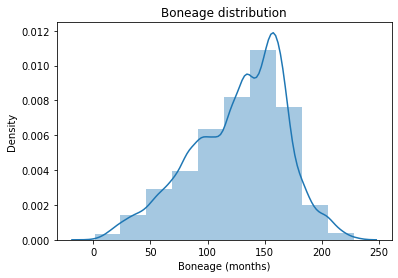

In [33]:
fig, ax = plt.subplots()
ax = sns.distplot(df['boneage'], bins=10)
ax.set(xlabel='Boneage (months)', ylabel='Density',
    title='Boneage distribution');

In [34]:
boneage_mean = df['boneage'].mean()#mean age
boneage_div = 2*df['boneage'].std()
print(boneage_mean,"  ",boneage_div)
df['boneage_zscore'] = df['boneage'].map(lambda x:
    (x - boneage_mean) / boneage_div)
df.dropna(inplace=True)

df['gender'] = df['male'].map(lambda x: 1 if x else 0)

df['boneage_category'] = pd.cut(df['boneage'], 10)

127.3207517246848    82.36404279879235


In [35]:
df['gender']
df['boneage_category']
df.head()
df.shape[0]

12611

In [0]:
raw_train_df, raw_valid_df = train_test_split(df, test_size=VALIDATION_FRACTION,
  random_state=2018)

In [37]:


raw_train_df.shape[0]
raw_valid_df.shape[0]

3153

In [38]:
 raw_valid_df.head()

,id,boneage,male,file,exists,boneage_zscore,gender,boneage_category
3482,5435,156,False,/gdrive/My Drive/boneage-training-dataset/5435...,True,0.348201,0,"(137.2, 159.9]"
3092,5004,100,False,/gdrive/My Drive/boneage-training-dataset/5004...,True,-0.331707,0,"(91.8, 114.5]"
10199,12917,94,False,/gdrive/My Drive/boneage-training-dataset/1291...,True,-0.404555,0,"(91.8, 114.5]"
4467,6521,69,False,/gdrive/My Drive/boneage-training-dataset/6521...,True,-0.708085,0,"(46.4, 69.1]"
6645,8947,120,False,/gdrive/My Drive/boneage-training-dataset/8947...,True,-0.088883,0,"(114.5, 137.2]"


In [39]:
raw_valid_df.loc[raw_valid_df['exists']==False,:]

,id,boneage,male,file,exists,boneage_zscore,gender,boneage_category


In [0]:
train_df = raw_train_df.groupby(['boneage_category', 'male']).apply(
  lambda x: x.sample(500, replace=True)).reset_index(drop=True)
valid_df, test_df = train_test_split(raw_valid_df,

  test_size=VALIDATION_FRACTION, random_state=2019)

In [0]:
valid_df

,id,boneage,male,file,exists,boneage_zscore,gender,boneage_category
1174,2680,132,False,/gdrive/My Drive/boneage-training-dataset/2680...,True,0.057044,0,"(114.5, 137.2]"
2640,4314,120,False,/gdrive/My Drive/boneage-training-dataset/4314...,True,-0.088666,0,"(114.5, 137.2]"
4144,6162,162,True,/gdrive/My Drive/boneage-training-dataset/6162...,True,0.421320,1,"(159.9, 182.6]"
2043,3658,138,False,/gdrive/My Drive/boneage-training-dataset/3658...,True,0.129899,0,"(137.2, 159.9]"
10765,13557,82,False,/gdrive/My Drive/boneage-training-dataset/1355...,True,-0.550081,0,"(69.1, 91.8]"
...,...,...,...,...,...,...,...,...
1933,3534,180,False,/gdrive/My Drive/boneage-training-dataset/3534...,True,0.639885,0,"(159.9, 182.6]"
8542,11061,120,False,/gdrive/My Drive/boneage-training-dataset/1106...,True,-0.088666,0,"(114.5, 137.2]"
9840,12527,120,False,/gdrive/My Drive/boneage-training-dataset/1252...,True,-0.088666,0,"(114.5, 137.2]"
5125,7259,84,True,/gdrive/My Drive/boneage-training-dataset/7259...,True,-0.525796,1,"(69.1, 91.8]"


In [0]:
train_df.shape[0]

10000

In [0]:
test_df

,id,boneage,male,file,exists,boneage_zscore,gender,boneage_category
3441,5395,228,True,/gdrive/My Drive/boneage-training-dataset/5395...,True,1.222725,1,"(205.3, 228.0]"
631,2087,84,True,/gdrive/My Drive/boneage-training-dataset/2087...,True,-0.525796,1,"(69.1, 91.8]"
1663,3232,174,True,/gdrive/My Drive/boneage-training-dataset/3232...,True,0.567030,1,"(159.9, 182.6]"
6316,8584,144,False,/gdrive/My Drive/boneage-training-dataset/8584...,True,0.202754,0,"(137.2, 159.9]"
7993,10450,50,False,/gdrive/My Drive/boneage-training-dataset/1045...,True,-0.938642,0,"(46.4, 69.1]"
...,...,...,...,...,...,...,...,...
10968,13788,168,True,/gdrive/My Drive/boneage-training-dataset/1378...,True,0.494175,1,"(159.9, 182.6]"
7433,9826,114,True,/gdrive/My Drive/boneage-training-dataset/9826...,True,-0.161521,1,"(91.8, 114.5]"
7564,9967,120,False,/gdrive/My Drive/boneage-training-dataset/9967...,True,-0.088666,0,"(114.5, 137.2]"
10584,13353,96,True,/gdrive/My Drive/boneage-training-dataset/1335...,True,-0.380086,1,"(91.8, 114.5]"


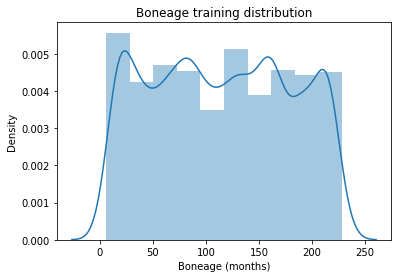

In [41]:

fig, ax = plt.subplots()
ax = sns.distplot(train_df['boneage'], bins=10)
ax.set(xlabel='Boneage (months)', ylabel='Density',
    title='Boneage training distribution');

In [0]:

import keras
optim = keras.optimizers.Nadam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.0003)

In [0]:
#############################################dont exceute
weight_path = "{}_weights.best.hdf5".format('bone_age3')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,save_best_only=True, mode='min', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8,patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=5,min_lr=0.00006)
early = EarlyStopping(monitor="val_loss", mode="min", patience=8)
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [0]:
BATCH_SIZE_TEST = len(test_df) // 3
STEP_SIZE_TEST = 3
STEP_SIZE_TRAIN = len(train_df) // BATCH_SIZE_TRAIN
STEP_SIZE_VALID = len(valid_df) // BATCH_SIZE_VAL

In [0]:
def gen_2inputs(imgDatGen, df, batch_size, seed, img_size):
    gen_img = imgDatGen.flow_from_dataframe(dataframe=df,
        x_col='file', y_col='boneage_zscore',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='rgb',
        drop_duplicates=False)
    
    gen_gender = imgDatGen.flow_from_dataframe(dataframe=df,
        x_col='file', y_col='gender',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='rgb',
        drop_duplicates=False)
    
    while True:
        X1i = gen_img.next()
        X2i = gen_gender.next()
        yield [X1i[0], X2i[1]], X1i[1]

In [0]:
def test_gen_2inputs(imgDatGen, df, batch_size, img_size):
    gen_img = imgDatGen.flow_from_dataframe(dataframe=df,
        x_col='file', y_col='boneage_zscore',
        batch_size=batch_size, shuffle=False, class_mode='other',
        target_size=img_size, color_mode='rgb',
        drop_duplicates=False)
    
    gen_gender = imgDatGen.flow_from_dataframe(dataframe=df,
        x_col='file', y_col='gender',
        batch_size=batch_size, shuffle=False, class_mode='other',
        target_size=img_size, color_mode='rgb',
        drop_duplicates=False)
    
    while True:
        X1i = gen_img.next()
        X2i = gen_gender.next()
        yield [X1i[0], X2i[1]], X1i[1]

In [0]:
train_idg = ImageDataGenerator(zoom_range=0.2,
                               fill_mode='nearest',
                               rotation_range=25,  
                               width_shift_range=0.25,  
                               height_shift_range=0.25,  
                               vertical_flip=False, 
                               horizontal_flip=True,
                               shear_range = 0.2,
                               samplewise_center=False, 
                               samplewise_std_normalization=False)

val_idg = ImageDataGenerator(width_shift_range=0.25, height_shift_range=0.25, horizontal_flip=True)

train_flow = gen_2inputs(train_idg, train_df, BATCH_SIZE_TRAIN, SEED, IMG_SIZE)

valid_flow = gen_2inputs(val_idg, valid_df, BATCH_SIZE_VAL, SEED, IMG_SIZE)

test_idg = ImageDataGenerator()

test_flow = test_gen_2inputs(test_idg, test_df, 789, IMG_SIZE)

In [0]:

def mae_months(in_gt, in_pred):
    return mean_absolute_error(boneage_div * in_gt, boneage_div * in_pred)

In [49]:

i1 = Input(shape=(299, 299, 3), name='input_img')
i2 = Input(shape=(1,), name='input_gender')
base = InceptionV3(input_tensor=i1, input_shape=(299, 299, 3), include_top=False, weights=None)

feature_img = base.get_layer(name='mixed10').output
feature_img = AveragePooling2D((2, 2))(feature_img)
feature_img = Flatten()(feature_img)
feature_gender = Dense(32, activation='relu')(i2)
feature = concatenate([feature_img, feature_gender], axis=1)

# feature = feature_img
o = Dense(1000, activation='relu')(feature)
o = Dense(1000, activation='relu')(o)
o = Dense(1)(o)
model = Model(inputs=[i1, i2], outputs=o)
optimizer = Adam(lr=1e-3)
model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mae'])

print('==================================================')
print('======= Training Model on Boneage Dataset ========')
print('==================================================')

#print('current time: %s' % str(datetime.now()))

model.summary()



======= Training Model on Boneage Dataset ========
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 149, 149, 32) 864         input_img[0][0]                  
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 149, 149, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 149, 149, 32) 0           batch_normalization_95[0][0]     
_________________________________________

In [0]:
filepath='/gdrive/My Drive/incpCb.h5'
checkpoints=ModelCheckpoint(filepath,monitor='loss',verbose=1,save_best_only=True,mode='min')
#callbacks_list=[checkpoints]

#checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,save_best_only=True, mode='min', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8,patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=5,min_lr=0.00006)
early = EarlyStopping(monitor="val_loss", mode="min", patience=8)
callbacks_list = [ early, reduceLROnPlat,checkpoints]

In [27]:
model_history =model.fit_generator(generator=train_flow,
                                    steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_flow,
                                    validation_steps=STEP_SIZE_VALID, epochs=40,callbacks=callbacks_list)
model.save('/gdrive/My Drive/ep40(incp).h5')



Epoch 1/40
Found 2364 validated image filenames.
Found 2364 validated image filenames.
Found 10000 validated image filenames.
Found 10000 validated image filenames.


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:709: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


312/312 [==============================] - 3175s 10s/step - loss: 1.2900 - mean_absolute_error: 1.2900 - val_loss: 0.4349 - val_mean_absolute_error: 0.4349

Epoch 00001: loss improved from inf to 1.29077, saving model to /gdrive/My Drive/incpCb.h5
Epoch 2/40
312/312 [==============================] - 1185s 4s/step - loss: 0.5287 - mean_absolute_error: 0.5287 - val_loss: 0.7125 - val_mean_absolute_error: 0.7125

Epoch 00002: loss improved from 1.29077 to 0.52866, saving model to /gdrive/My Drive/incpCb.h5
Epoch 3/40
312/312 [==============================] - 1151s 4s/step - loss: 0.4930 - mean_absolute_error: 0.4930 - val_loss: 0.5138 - val_mean_absolute_error: 0.5138

Epoch 00003: loss improved from 0.52866 to 0.49287, saving model to /gdrive/My Drive/incpCb.h5
Epoch 4/40
312/312 [==============================] - 1118s 4s/step - loss: 0.5671 - mean_absolute_error: 0.5671 - val_loss: 0.5464 - val_mean_absolute_error: 0.5464

Epoch 00004: loss did not improve from 0.49287
Epoch 5/40
312

In [0]:
new_model.save('/gdrive/My Drive/75+10(reg).h5')

In [50]:
from tensorflow.keras.models import load_model
import tensorflow as tf

new_model=load_model("/gdrive/My Drive/ep40(incp).h5", custom_objects = { "tf": tf })

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
from tensorflow.keras.models import load_model
import tensorflow as tf

new_model=load_model("/gdrive/My Drive/epoch75.h5", custom_objects = { "tf": tf })
'''
checkpoints=ModelCheckpoint(filepath,monitor='loss',verbose=1,save_best_only=True,mode='min')
#callbacks_list=[checkpoints]


#checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,save_best_only=True, mode='min', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8,patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=5,min_lr=0.00006)
early = EarlyStopping(monitor="val_loss", mode="min", patience=8)
callbacks_list = [checkpoints, early, reduceLROnPlat]
'''

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


'\ncheckpoints=ModelCheckpoint(filepath,monitor=\'loss\',verbose=1,save_best_only=True,mode=\'min\')\n#callbacks_list=[checkpoints]\n\n\n#checkpoint = ModelCheckpoint(weight_path, monitor=\'val_loss\', verbose=1,save_best_only=True, mode=\'min\', save_weights_only=True)\n\nreduceLROnPlat = ReduceLROnPlateau(monitor=\'val_loss\', factor=0.8,patience=10, verbose=1, mode=\'auto\', min_delta=0.0001, cooldown=5,min_lr=0.00006)\nearly = EarlyStopping(monitor="val_loss", mode="min", patience=8)\ncallbacks_list = [checkpoints, early, reduceLROnPlat]\n'

In [0]:
new_history=new_model.fit_generator(generator=train_flow,
                                    steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_flow,
                                    validation_steps=STEP_SIZE_VALID, epochs=17)
new_model.save('/gdrive/My Drive/ep75+17.h5')

Epoch 1/17
Found 10000 validated image filenames.
Found 10000 validated image filenames.
311/312 [============================>.] - ETA: 5s - loss: 0.1089 Epoch 1/17
Found 2364 validated image filenames.
Found 2364 validated image filenames.
312/312 [==============================] - 1919s 6s/step - loss: 0.1088 - val_loss: 0.1106
Epoch 2/17
 90/312 [=======>......................] - ETA: 6:59 - loss: 0.1068

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-88-fc192ea15f20>", line 3, in <module>
    validation_steps=STEP_SIZE_VALID, epochs=17)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/engine/training.py", line 1296, in fit_generator
    steps_name='steps_per_epoch')
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/engine/training_generator.py", line 221, in model_iteration
    batch_data = _get_next_batch(generator)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/engine/training_generator.py", line 363, in _get_next_batch
    generator_output = next(generator)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/utils/data_utils.py", line 922, in get
    six.reraise(*sys.exc_info())
  File "/usr/local/lib/python3.6/

FileNotFoundError: ignored

In [0]:

k.save('/gdrive/My Drive/ep75+7.h5')

In [0]:
new_model.save('/gdrive/My Drive/newmod.h5')

In [0]:
new_model.save('/gdrive/My Drive/epoch75.h5')

In [0]:
import tensorflow as tf

from tensorflow.keras.models import load_model
md=load_model("/gdrive/My Drive/ep75+14.h5", custom_objects = { "tf": tf })

In [0]:
#4rd time
md3=md.fit_generator(generator=train_flow,
                                    steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_flow,
                                    validation_steps=STEP_SIZE_VALID, epochs=15)
md.save('/gdrive/My Drive/fourthlr006.h5')

Epoch 1/15
Found 10000 validated image filenames.
Found 10000 validated image filenames.
 19/312 [>.............................] - ETA: 1:07:36 - loss: 0.0924

In [0]:
from tensorflow.keras.models import load_model
import tensorflow as tf
k=load_model('/gdrive/My Drive/epoch75.h5', custom_objects = { "tf": tf })

In [0]:
p=[7049,12447]
test=df.loc[df['id'].isin(p)]
test_flow1 = test_gen_2inputs(test_idg, test, 2, IMG_SIZE)
testx,testy=next(test_flow1)

Found 2 validated image filenames.
Found 2 validated image filenames.


In [0]:
import tensorflow as tf
model.save('/gdrive/My Drive/01epoch.h5')

#m=keras.models.load_model('modelsavedvgg.h5', custom_objects = { "tf": tf })
#k=load_model("modelsavedvgg.h5", custom_objects = { "tf": tf })

In [0]:
files = ['/gdrive/My Drive/boneage-test-dataset/' + str(i) + '.png' for i in df['id']]
df_input['file'] = files
df_input['exists'] = df_input['file'].map(os.path.exists)

In [0]:
ep=[]
loss=[]
for i in range(1,81):
  ep.append(i)
loss=[0.7060,0.6687,0.6441,0.5886,0.5387,0.5884,0.5137,0.4814,0.4584,0.4307,0.4025,0.3769,0.3560,0.3347,0.3022,0.2746,0.2573,0.2464,0.2319,0.2247,0.2113,0.2045,0.1985,0.1900,0.1856,0.1845,0.1859,0.1779,0.1672,0.1649,0.1613,0.1588,0.1519,0.1545,0.1548,0.1547,0.1478,0.1492,0.1455,0.1412,0.1424,0.1385,0.1346,0.1368,0.1323,0.1333,0.1297,0.1286,0.1258,0.1224,0.1219,0.1203,0.1189,0.1221,0.1181,0.1170,0.1142,0.1107,0.1129,0.1121,0.1096,0.1097,0.1087,0.1105,0.1072,0.1135,0.1044,0.1060,0.1049,0.1028,0.1042,0.1082,0.1024,0.1015,0.1012,0.0992,0.1012,0.0998,0.1005,0.0982]

80
80


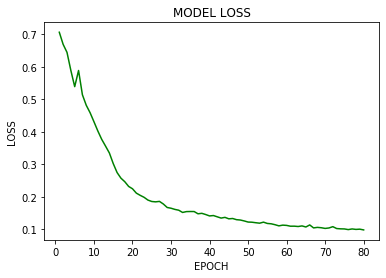

In [0]:
print(len(loss))
print(len(ep))
import matplotlib.pyplot as plt
plt.plot(ep,loss,'g')
plt.title("MODEL LOSS")
plt.ylabel("LOSS")
plt.xlabel("EPOCH")
 
plt.show()

In [51]:
test_X,test_Y=next(test_flow)

Found 789 validated image filenames.
Found 789 validated image filenames.


In [52]:
plt.style.use("dark_background")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'
print(boneage_div)
#print(model.predict(test_X, batch_size = 263, verbose = True))
print(boneage_mean)
pred_Y = boneage_div*new_model.predict(test_X, batch_size = 263, verbose = True)+boneage_mean
test_Y_months = boneage_div*test_Y+boneage_mean
'''
ord_idx = np.argsort(test_Y)
ord_idx = ord_idx[np.linspace(0, len(ord_idx)-1, 4).astype(int)] # take 8 evenly spaced ones
fig, m_axs = plt.subplots(2, 2, figsize = (8, 8))
for (idx, c_ax) in zip(ord_idx, m_axs.flatten()):
    cur_img = test_X[0][idx:(idx+1)]
    c_ax.imshow(cur_img[0, :,:,0], cmap = 'bone')
    
    c_ax.set_title('Age: %2.1fY\nPredicted Age: %2.1fY' % (test_Y_months[idx]/42.0, 
                                                           pred_Y[idx]))
    c_ax.axis('off')
#fig.savefig('trained_img_predictions.png', dpi = 300)
'''

82.36404279879235
127.3207517246848
789/789 [==============================] - 14s 18ms/sample


"\nord_idx = np.argsort(test_Y)\nord_idx = ord_idx[np.linspace(0, len(ord_idx)-1, 4).astype(int)] # take 8 evenly spaced ones\nfig, m_axs = plt.subplots(2, 2, figsize = (8, 8))\nfor (idx, c_ax) in zip(ord_idx, m_axs.flatten()):\n    cur_img = test_X[0][idx:(idx+1)]\n    c_ax.imshow(cur_img[0, :,:,0], cmap = 'bone')\n    \n    c_ax.set_title('Age: %2.1fY\nPredicted Age: %2.1fY' % (test_Y_months[idx]/42.0, \n                                                           pred_Y[idx]))\n    c_ax.axis('off')\n#fig.savefig('trained_img_predictions.png', dpi = 300)\n"

In [53]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_Y_months,pred_Y)

44.18882393202401

In [0]:
p=pred_Y.reshape(-1,1)
print(p.shape)
p=p.flatten()
p.shape
#print(p)
type(p)

(788, 1)


numpy.ndarray

In [0]:
b=test_df['id']
pth=test_df['file']
b2=test_df['boneage']

In [0]:
#gender1=df['male']
a=abs(p-test_Y_months)
#print(a)
df=pd.DataFrame()
df['id']=b
df['act']=test_Y_months
df['pred']=p
a.flatten()
df['diff']=a
#df['path']=pth
#df['gender1']=gender1
#df['bonage1']=test_Y_months
#df['bonage2']=b2
#df.head()
sorted=df.sort_values('diff')
df=sorted
print("best cases")
print(sorted.head(100))
print("worst cases")
print(sorted.tail(50))
#df.to_csv('/gdrive/My Drive/guime.csv')

best cases
          id    act        pred       diff
2899    4794  120.0  118.424438   1.575562
4639    6720  120.0  118.424438   1.575562
3785    5777  120.0  118.424438   1.575562
4879    6989  120.0  118.424438   1.575562
10749  13539  120.0  118.424438   1.575562
...      ...    ...         ...        ...
1981    3586  108.0  118.424438  10.424438
10124  12836  108.0  118.424438  10.424438
3958    5966  108.0  118.424438  10.424438
5813    8032  108.0  118.424438  10.424438
4956    7072  108.0  118.424438  10.424438

[100 rows x 4 columns]
worst cases
          id    act        pred        diff
9472   12114  198.0  118.424438   79.575562
2452    4109  198.0  118.424438   79.575562
11825  14749   36.0  118.424438   82.424438
12147  15107   36.0  118.424438   82.424438
1890    3487   36.0  118.424438   82.424438
12353  15327   36.0  118.424438   82.424438
8291   10783   36.0  118.424438   82.424438
1043    2535   36.0  118.424438   82.424438
7494    9895   36.0  118.424438   82.4244

In [0]:
print(df['id'],df['diff'])

2899      4794
4639      6720
3785      5777
4879      6989
10749    13539
         ...  
2040      3655
248       1654
8802     11361
10309    13043
3441      5395
Name: id, Length: 788, dtype: int64 2899       1.575562
4639       1.575562
3785       1.575562
4879       1.575562
10749      1.575562
            ...    
2040     103.424438
248      104.424438
8802     106.424438
10309    109.575562
3441     109.575562
Name: diff, Length: 788, dtype: float64


In [0]:
df1=df[df['act']<=12]
df2=df.loc[(df['act']<=24) & (df['act']>12)]
df3=df.loc[(df['act']>24) &(df['act']<=36)]
df4=df.loc[(df['act']>36) &(df['act']<=48)]
df5=df.loc[(df['act']>48) &(df['act']<=60)]
df6=df.loc[(df['act']>60) &(df['act']<=72)]
df7=df.loc[(df['act']>72) &(df['act']<=84)]
df8=df.loc[(df['act']>84) &(df['act']<=96)]
df9=df.loc[(df['act']>96) &(df['act']<=108)]
df10=df.loc[(df['act']>108) &(df['act']<=120)]
df11=df.loc[(df['act']>120) &(df['act']<=132)]
df12=df.loc[(df['act']>132) &(df['act']<=144)]
df13=df.loc[(df['act']>144) &(df['act']<=156)]
df14=df.loc[(df['act']>156) &(df['act']<=168)]
df15=df.loc[(df['act']>168) &(df['act']<=180)]
df16=df.loc[(df['act']>180) &(df['act']<=192)]
df17=df.loc[(df['act']>192) &(df['act']<=204)]
df18=df.loc[(df['act']>204) &(df['act']<=216)]
df19=df.loc[(df['act']>216) &(df['act']<=228)]

In [0]:
print(mean_absolute_error(df1['act'],df1['pred']))
print(mean_absolute_error(df2['act'],df2['pred']))
print(mean_absolute_error(df3['act'],df3['pred']))
print(mean_absolute_error(df4['act'],df4['pred']))
print(mean_absolute_error(df5['act'],df5['pred']))
print(mean_absolute_error(df6['act'],df6['pred']))
print(mean_absolute_error(df7['act'],df7['pred']))
print(mean_absolute_error(df8['act'],df8['pred']))
print(mean_absolute_error(df9['act'],df9['pred']))
print(mean_absolute_error(df10['act'],df10['pred']))
print(mean_absolute_error(df11['act'],df11['pred']))
print(mean_absolute_error(df12['act'],df12['pred']))
print(mean_absolute_error(df13['act'],df13['pred']))
print(mean_absolute_error(df14['act'],df14['pred']))
print(mean_absolute_error(df15['act'],df15['pred']))
print(mean_absolute_error(df16['act'],df16['pred']))
print(mean_absolute_error(df17['act'],df17['pred']))
print(mean_absolute_error(df18['act'],df18['pred']))
print(mean_absolute_error(df19['act'],df19['pred']))

7.830768585205071
8.549108123779297
5.275413513183594
14.666978624131945
11.167550150553385
10.218318816154234
8.366297705698821
9.37790967597336
15.06360321044922
11.69335216175426
13.48546359963613
14.557658745260799
13.733514124033402
14.481881361741285
15.74964021381579
12.87321533203125
17.956851959228516
4.972078959147136
14.283538818359375


In [0]:
import pandas as pd
act=pd.DataFrame(test_Y_months)
p=pd.DataFrame(pred_Y)
diff=pd.DataFrame(abs(act-p))

In [0]:
print(diff)

             0
0    10.582367
1     0.304398
2    13.393234
3     3.731766
4     4.055359
..         ...
784   7.131027
785   6.037521
786  18.441940
787  10.144592
788   5.236938

[789 rows x 1 columns]


In [0]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_Y_months,pred_Y)

35.66464372818845

In [0]:
diff.describe()

,0
count,789.000000
mean,8.679776
std,9.055515
min,0.002960
25%,3.001083
50%,6.844193
75%,11.995346
max,126.242630


In [0]:
np.sqrt(((test_Y_months-pred_Y)**2).mean())


59.47480189976486

In [0]:

from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_Y_months,pred_Y)

35.66464372818845

In [0]:
from scipy import stats
t2,p2=stats.ttest_ind(test_Y_months,pred_Y)
print("t="+str(t2))
print("p="+str(p2))

t=[-0.393438]
p=[0.69404922]
